In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load the dataset
df = pd.read_csv('/content/student_lifestyle_dataset.csv')

In [ ]:
# Display basic information about the dataset
print("Shape of the dataset:", df.shape)
display(df.head())
print("\nDataset Information:")
print(df.info())
print("\nStatistical Summary:")
display(df.describe().T)

Shape of the dataset: (2000, 8)


Student_ID  Study_Hours_Per_Day  Extracurricular_Hours_Per_Day  \
0           1                  6.9                            3.8   
1           2                  5.3                            3.5   
2           3                  5.1                            3.9   
3           4                  6.5                            2.1   
4           5                  8.1                            0.6   

   Sleep_Hours_Per_Day  Social_Hours_Per_Day  Physical_Activity_Hours_Per_Day  \
0                  8.7                   2.8                              1.8   
1                  8.0                   4.2                              3.0   
2                  9.2                   1.2                              4.6   
3                  7.2                   1.7                              6.5   
4                  6.5                   2.2                              6.6   

    GPA Stress_Level  
0  2.99     Moderate  
1  2.75          Low  
2  2.67          Low  
3  2.88     Moderate  
4  3.51         High


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Student_ID                       2000 non-null   int64  
 1   Study_Hours_Per_Day              2000 non-null   float64
 2   Extracurricular_Hours_Per_Day    2000 non-null   float64
 3   Sleep_Hours_Per_Day              2000 non-null   float64
 4   Social_Hours_Per_Day             2000 non-null   float64
 5   Physical_Activity_Hours_Per_Day  2000 non-null   float64
 6   GPA                              2000 non-null   float64
 7   Stress_Level                     2000 non-null   object 
dtypes: float64(6), int64(1), object(1)
memory usage: 125.1+ KB
None

Statistical Summary:


count        mean         std   min     25%  \
Student_ID                       2000.0  1000.50000  577.494589  1.00  500.75   
Study_Hours_Per_Day              2000.0     7.47580    1.423888  5.00    6.30   
Extracurricular_Hours_Per_Day    2000.0     1.99010    1.155855  0.00    1.00   
Sleep_Hours_Per_Day              2000.0     7.50125    1.460949  5.00    6.20   
Social_Hours_Per_Day             2000.0     2.70455    1.688514  0.00    1.20   
Physical_Activity_Hours_Per_Day  2000.0     4.32830    2.514110  0.00    2.40   
GPA                              2000.0     3.11596    0.298674  2.24    2.90   

                                     50%      75%     max  
Student_ID                       1000.50  1500.25  2000.0  
Study_Hours_Per_Day                 7.40     8.70    10.0  
Extracurricular_Hours_Per_Day       2.00     3.00     4.0  
Sleep_Hours_Per_Day                 7.50     8.80    10.0  
Social_Hours_Per_Day                2.60     4.10     6.0  
Physical_Activity_Hours_Per_Day     4.10     6.10    13.0  
GPA                                 3.11     3.33     4.0

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
# Check for missing and duplicated values
print(f'\nMissing values: {df.isna().sum().sum()}')
print(f'Duplicated values: {df.duplicated().sum()}')


Missing values: 0
Duplicated values: 0


In [ ]:
# Display the number of unique values in each column
print("\nUnique Values in Each Column:")
print(df.nunique())


Unique Values in Each Column:
Student_ID                         2000
Study_Hours_Per_Day                  51
Extracurricular_Hours_Per_Day        41
Sleep_Hours_Per_Day                  51
Social_Hours_Per_Day                 61
Physical_Activity_Hours_Per_Day     118
GPA                                 158
Stress_Level                          3
dtype: int64


In [ ]:
# Separate numerical and categorical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
non_numerical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Display the lists of numerical and categorical columns
print("\nNumerical Columns:", numerical_columns)
print("Categorical Columns:", non_numerical_columns)


Numerical Columns: ['Student_ID', 'Study_Hours_Per_Day', 'Extracurricular_Hours_Per_Day', 'Sleep_Hours_Per_Day', 'Social_Hours_Per_Day', 'Physical_Activity_Hours_Per_Day', 'GPA']
Categorical Columns: ['Stress_Level']


In [ ]:
# Display unique values for each categorical column
for col in non_numerical_columns:
    print(f"\nColumn: {col}")
    print(f"Unique Values: {df[col].unique()}")


Column: Stress_Level
Unique Values: ['Moderate' 'Low' 'High']


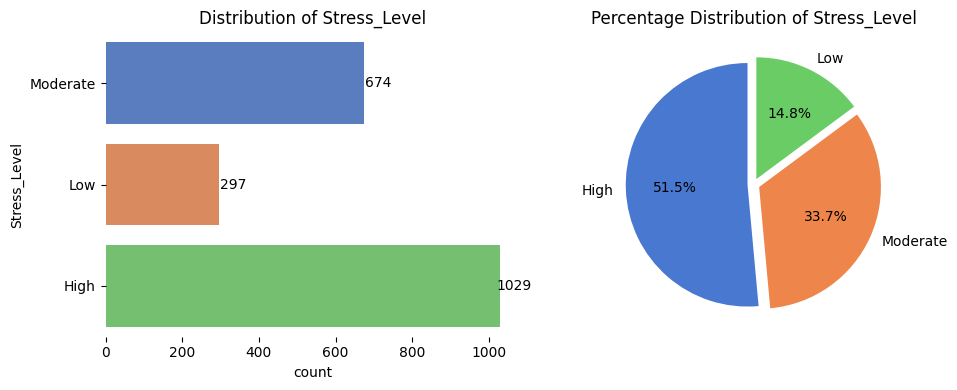

In [ ]:
column_name = 'Stress_Level'
plt.figure(figsize=(10, 4))

# First subplot: Count plot
plt.subplot(1, 2, 1)
sns.countplot(y=column_name, data=df, palette='muted')
plt.title(f'Distribution of {column_name}')

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='center', va='center', xytext=(10, 0), textcoords='offset points')

sns.despine(left=True, bottom=True)

# Second subplot: Pie chart
plt.subplot(1, 2, 2)
df[column_name].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('muted'), startangle=90, explode=[0.05]*df[column_name].nunique())
plt.title(f'Percentage Distribution of {column_name}')
plt.ylabel('')

plt.tight_layout()
plt.show()

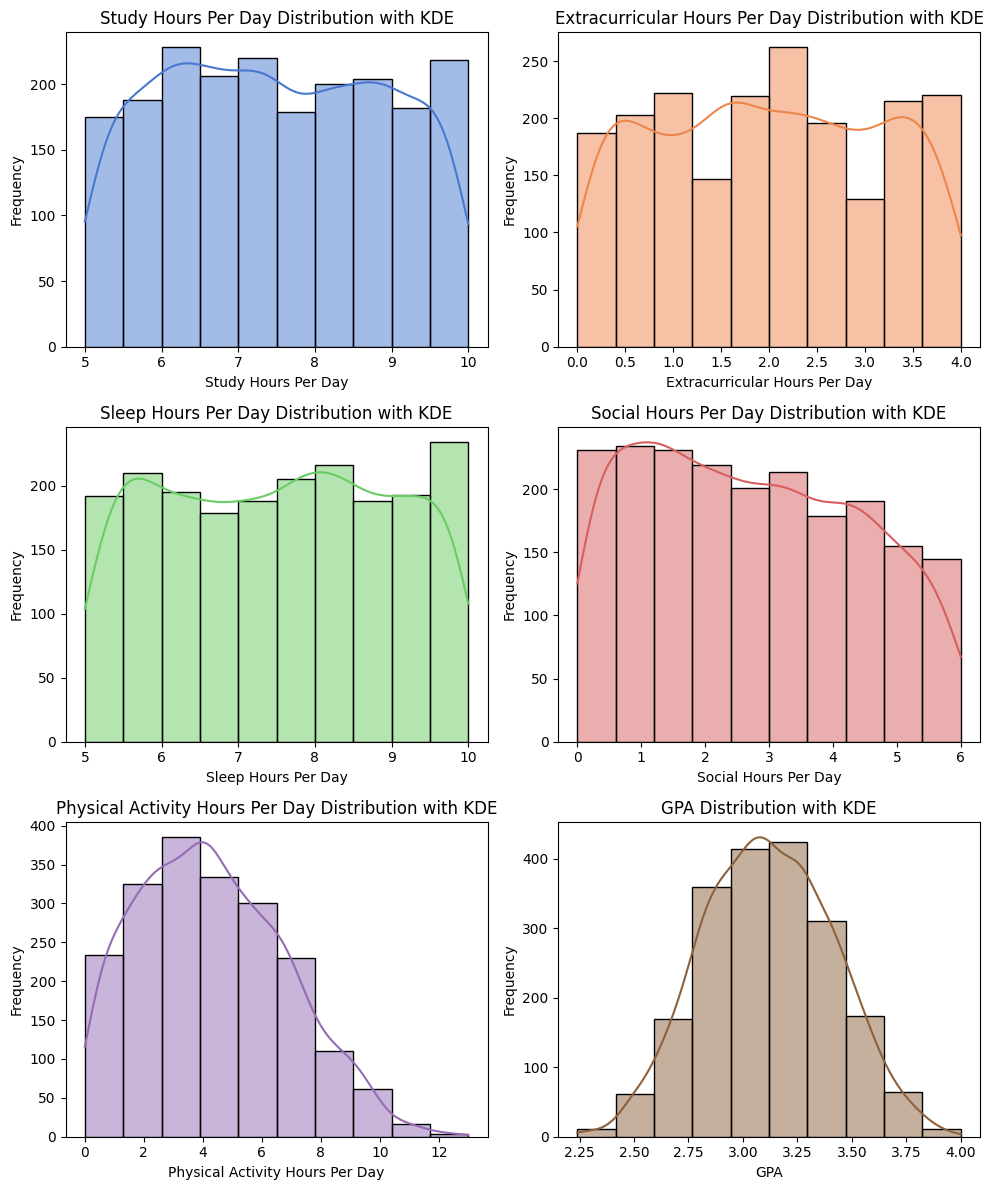

In [ ]:
# Function to perform univariate analysis for numeric columns
def univariate_analysis(data, columns):
    plt.figure(figsize=(10, 12))

    muted_colors = sns.color_palette("muted", len(columns))

    for i, column in enumerate(columns):
        plt.subplot(3, 2, i + 1)
        sns.histplot(data[column], kde=True, bins=10, color=muted_colors[i])
        plt.title(f'{column.replace("_", " ")} Distribution with KDE')
        plt.xlabel(column.replace('_', ' '))
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

columns_to_analyze = ['Study_Hours_Per_Day', 'Extracurricular_Hours_Per_Day',
                       'Sleep_Hours_Per_Day', 'Social_Hours_Per_Day',
                       'Physical_Activity_Hours_Per_Day', 'GPA']

univariate_analysis(df, columns_to_analyze)

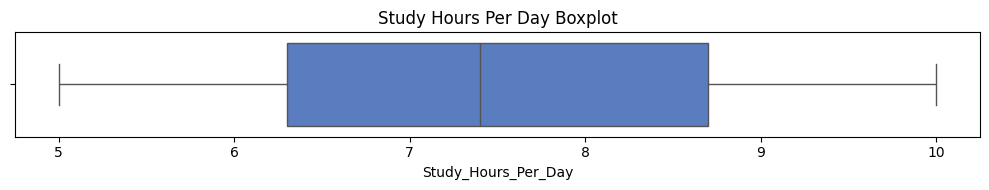


Summary Statistics for Study Hours Per Day:
 count    2000.000000
mean        7.475800
std         1.423888
min         5.000000
25%         6.300000
50%         7.400000
75%         8.700000
max        10.000000
Name: Study_Hours_Per_Day, dtype: float64


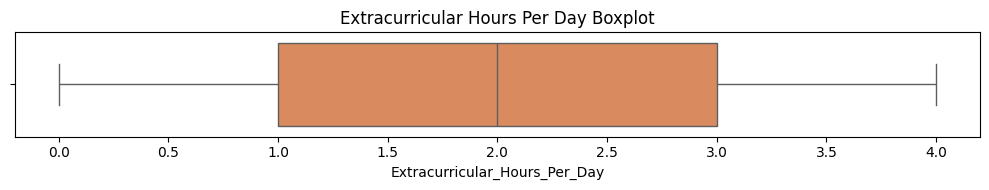


Summary Statistics for Extracurricular Hours Per Day:
 count    2000.000000
mean        1.990100
std         1.155855
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: Extracurricular_Hours_Per_Day, dtype: float64


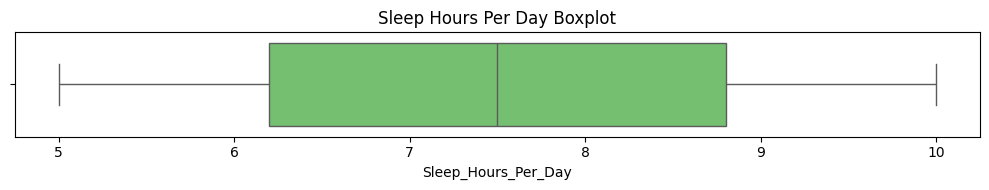


Summary Statistics for Sleep Hours Per Day:
 count    2000.000000
mean        7.501250
std         1.460949
min         5.000000
25%         6.200000
50%         7.500000
75%         8.800000
max        10.000000
Name: Sleep_Hours_Per_Day, dtype: float64


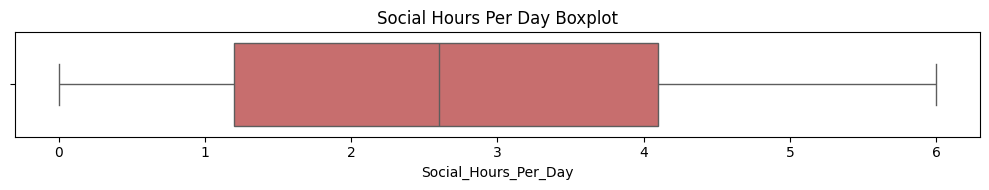


Summary Statistics for Social Hours Per Day:
 count    2000.000000
mean        2.704550
std         1.688514
min         0.000000
25%         1.200000
50%         2.600000
75%         4.100000
max         6.000000
Name: Social_Hours_Per_Day, dtype: float64


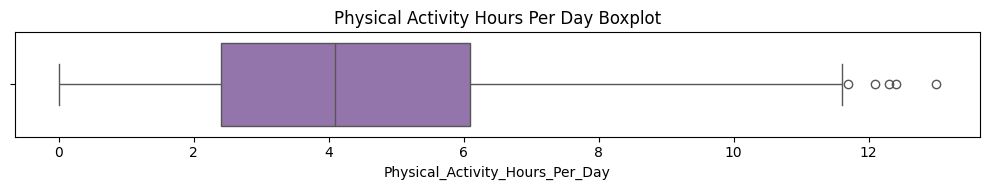


Summary Statistics for Physical Activity Hours Per Day:
 count    2000.00000
mean        4.32830
std         2.51411
min         0.00000
25%         2.40000
50%         4.10000
75%         6.10000
max        13.00000
Name: Physical_Activity_Hours_Per_Day, dtype: float64


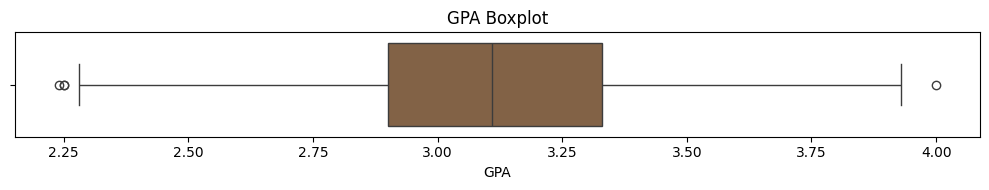


Summary Statistics for GPA:
 count    2000.000000
mean        3.115960
std         0.298674
min         2.240000
25%         2.900000
50%         3.110000
75%         3.330000
max         4.000000
Name: GPA, dtype: float64


In [ ]:
# Function to perform univariate analysis for numeric columns
def univariate_analysis(data, column, title):
    plt.figure(figsize=(10, 2))

    # Define a muted color palette
    color = sns.color_palette("muted")[columns_to_analyze.index(column)]

    sns.boxplot(x=data[column], color=color)
    plt.title(f'{title} Boxplot')

    plt.tight_layout()
    plt.show()

    print(f'\nSummary Statistics for {title}:\n', data[column].describe())

# List of columns to analyze
columns_to_analyze = ['Study_Hours_Per_Day', 'Extracurricular_Hours_Per_Day',
                       'Sleep_Hours_Per_Day', 'Social_Hours_Per_Day',
                       'Physical_Activity_Hours_Per_Day', 'GPA']

# Iterate through columns and perform univariate analysis
for column in columns_to_analyze:
    univariate_analysis(df, column, column.replace('_', ' '))

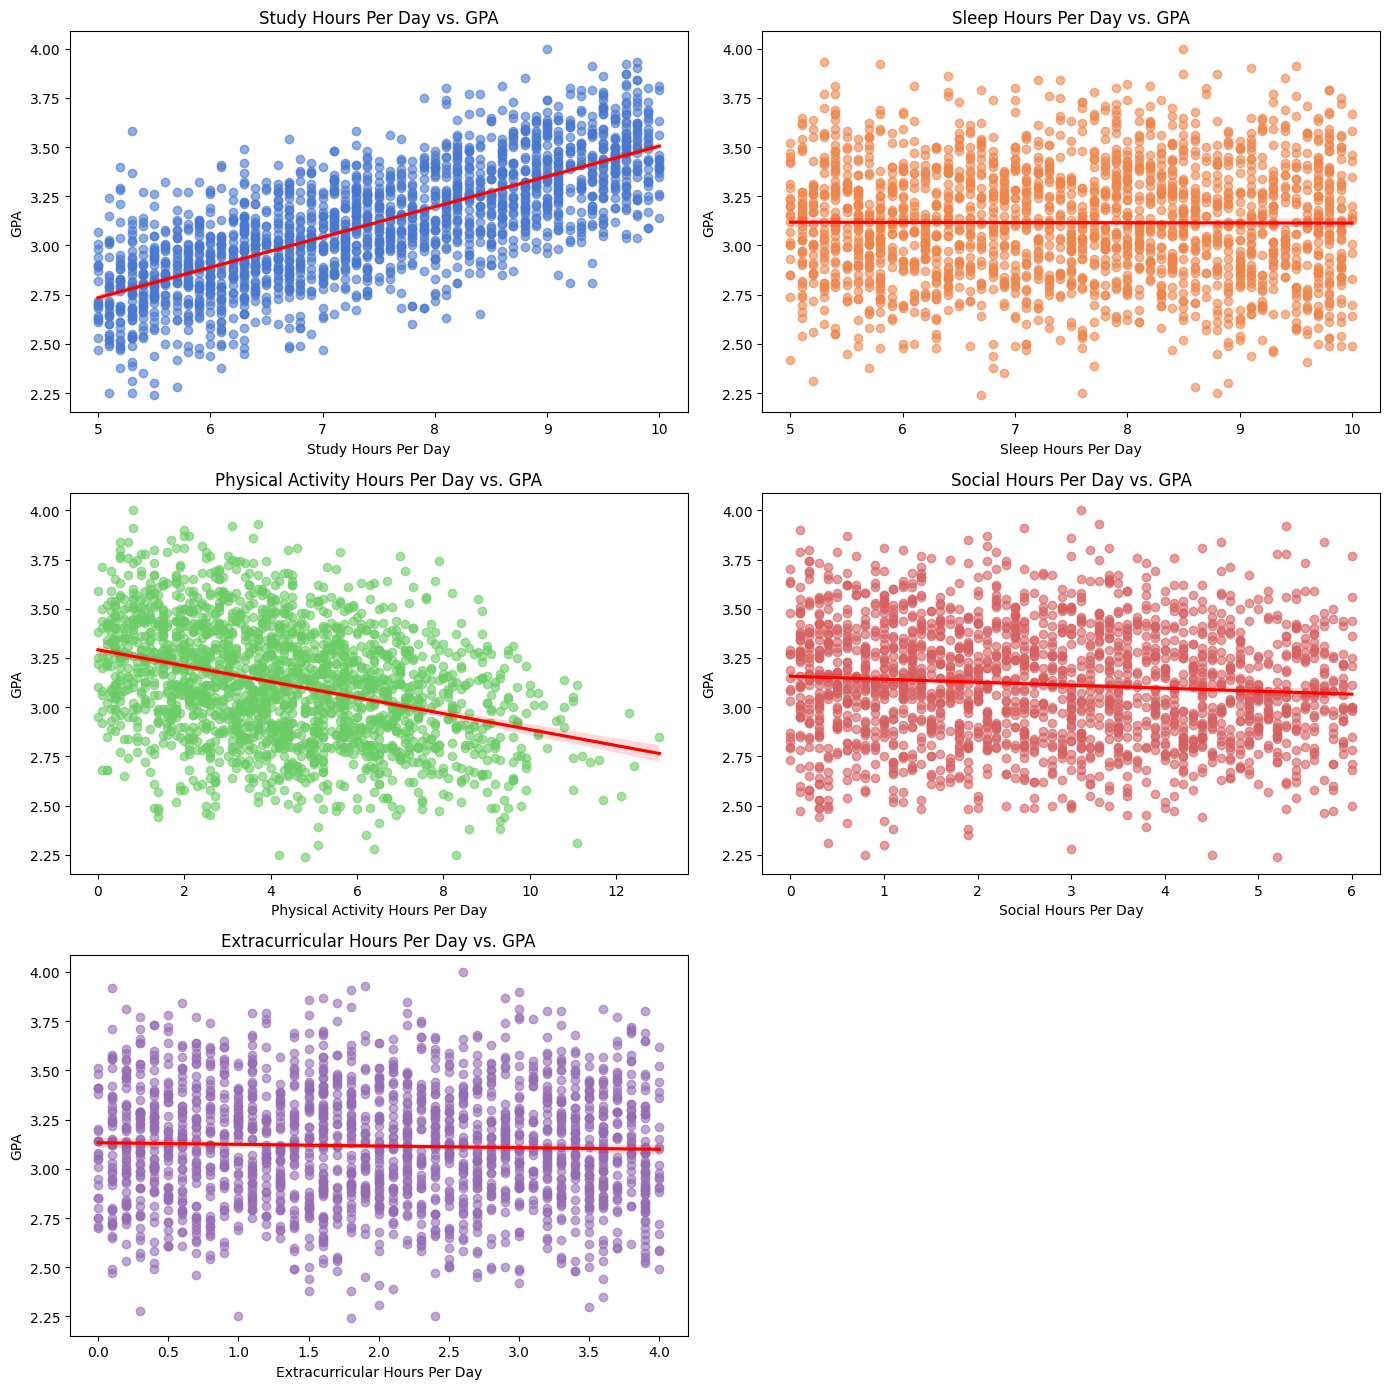

In [ ]:
# Define muted colors from the palette
muted_colors = sns.color_palette("muted")

# Scatter plots with linear regression lines
plt.figure(figsize=(14, 14))

# Study Hours vs. GPA
plt.subplot(3, 2, 1)
sns.regplot(x='Study_Hours_Per_Day', y='GPA', data=df,
            color=muted_colors[0], scatter_kws={'alpha':0.6}, line_kws={'color': 'red'})
plt.title('Study Hours Per Day vs. GPA')
plt.xlabel('Study Hours Per Day')
plt.ylabel('GPA')

# Sleep Hours vs. GPA
plt.subplot(3, 2, 2)
sns.regplot(x='Sleep_Hours_Per_Day', y='GPA', data=df,
            color=muted_colors[1], scatter_kws={'alpha':0.6}, line_kws={'color': 'red'})
plt.title('Sleep Hours Per Day vs. GPA')
plt.xlabel('Sleep Hours Per Day')
plt.ylabel('GPA')

# Physical Activity Hours vs. GPA
plt.subplot(3, 2, 3)
sns.regplot(x='Physical_Activity_Hours_Per_Day', y='GPA', data=df,
            color=muted_colors[2], scatter_kws={'alpha':0.6}, line_kws={'color': 'red'})
plt.title('Physical Activity Hours Per Day vs. GPA')
plt.xlabel('Physical Activity Hours Per Day')
plt.ylabel('GPA')

# Social Hours vs. GPA
plt.subplot(3, 2, 4)
sns.regplot(x='Social_Hours_Per_Day', y='GPA', data=df,
            color=muted_colors[3], scatter_kws={'alpha':0.6}, line_kws={'color': 'red'})
plt.title('Social Hours Per Day vs. GPA')
plt.xlabel('Social Hours Per Day')
plt.ylabel('GPA')

# Extracurricular Hours vs. GPA
plt.subplot(3, 2, 5)
sns.regplot(x='Extracurricular_Hours_Per_Day', y='GPA', data=df,
            color=muted_colors[4], scatter_kws={'alpha':0.6}, line_kws={'color': 'red'})
plt.title('Extracurricular Hours Per Day vs. GPA')
plt.xlabel('Extracurricular Hours Per Day')
plt.ylabel('GPA')

plt.tight_layout()
plt.show()


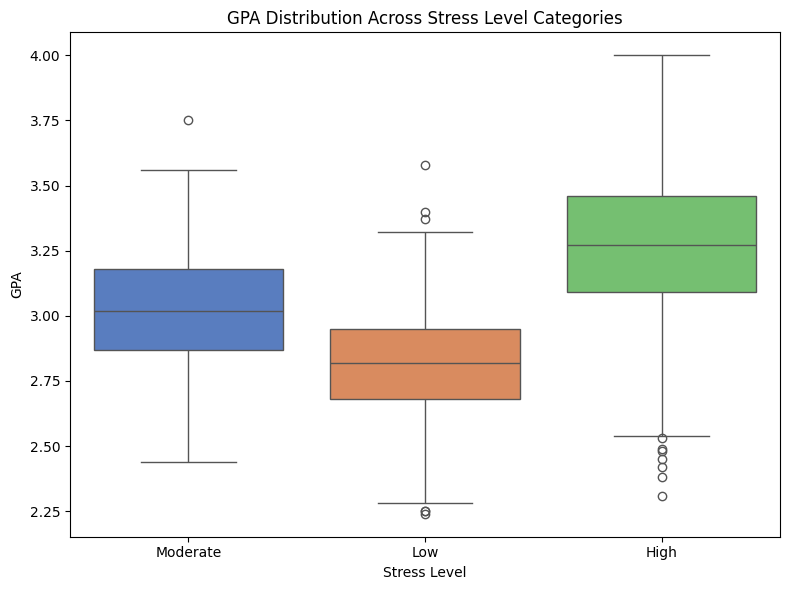

In [ ]:
# Boxplot for GPA across different Stress_Level categories
plt.figure(figsize=(8, 6))
sns.boxplot(x='Stress_Level', y='GPA', data=df, palette='muted')

plt.title('GPA Distribution Across Stress Level Categories')
plt.xlabel('Stress Level')
plt.ylabel('GPA')

# Display the plot
plt.tight_layout()
plt.show()

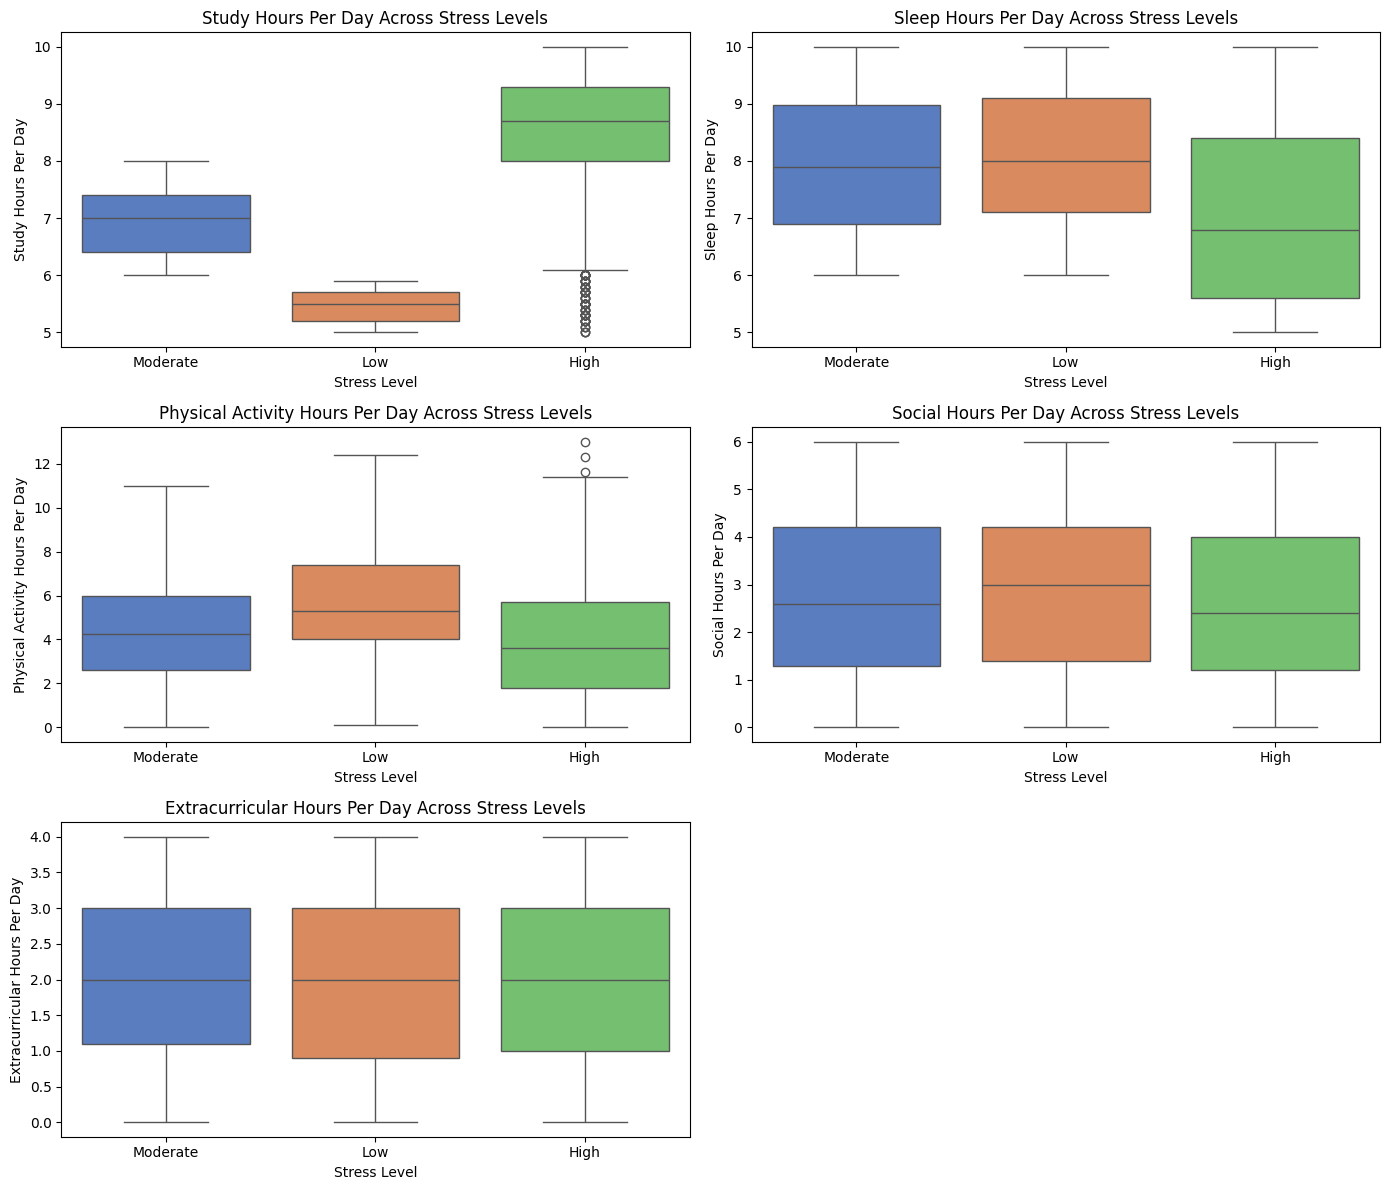

In [ ]:
numerical_features = [
    'Study_Hours_Per_Day',
    'Sleep_Hours_Per_Day',
    'Physical_Activity_Hours_Per_Day',
    'Social_Hours_Per_Day',
    'Extracurricular_Hours_Per_Day'
]

# Create boxplots for each numerical feature grouped by Stress_Level
plt.figure(figsize=(14, 12))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='Stress_Level', y=feature, data=df, palette='muted')
    plt.title(f'{feature.replace("_", " ")} Across Stress Levels')
    plt.xlabel('Stress Level')
    plt.ylabel(feature.replace("_", " "))

plt.tight_layout()
plt.show()

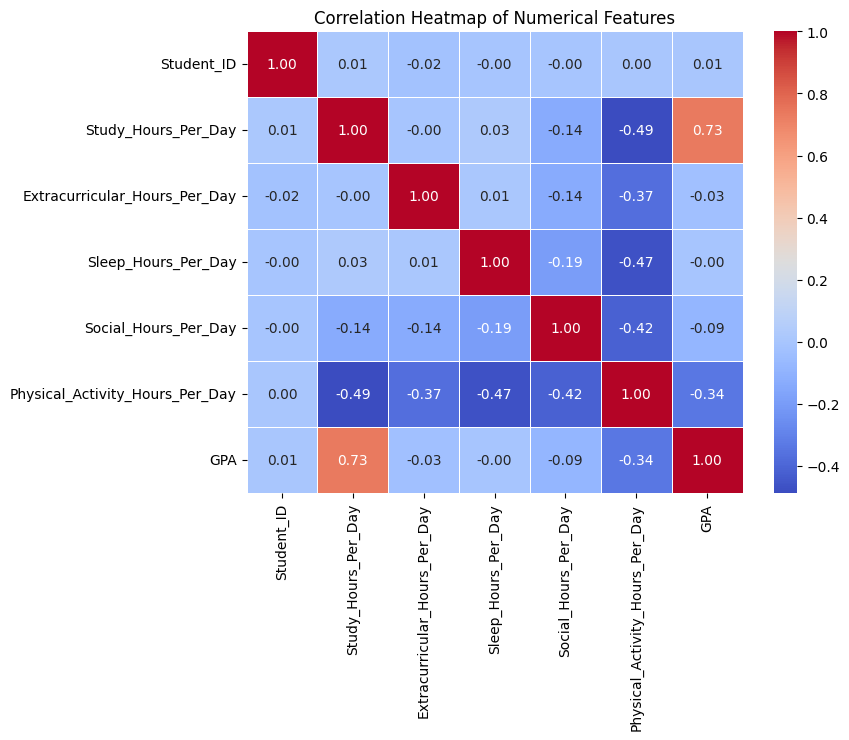

In [ ]:
# Plotting a correlation heatmap for numerical variables
plt.figure(figsize=(8, 6))
numerical_columns = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_columns.corr()

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

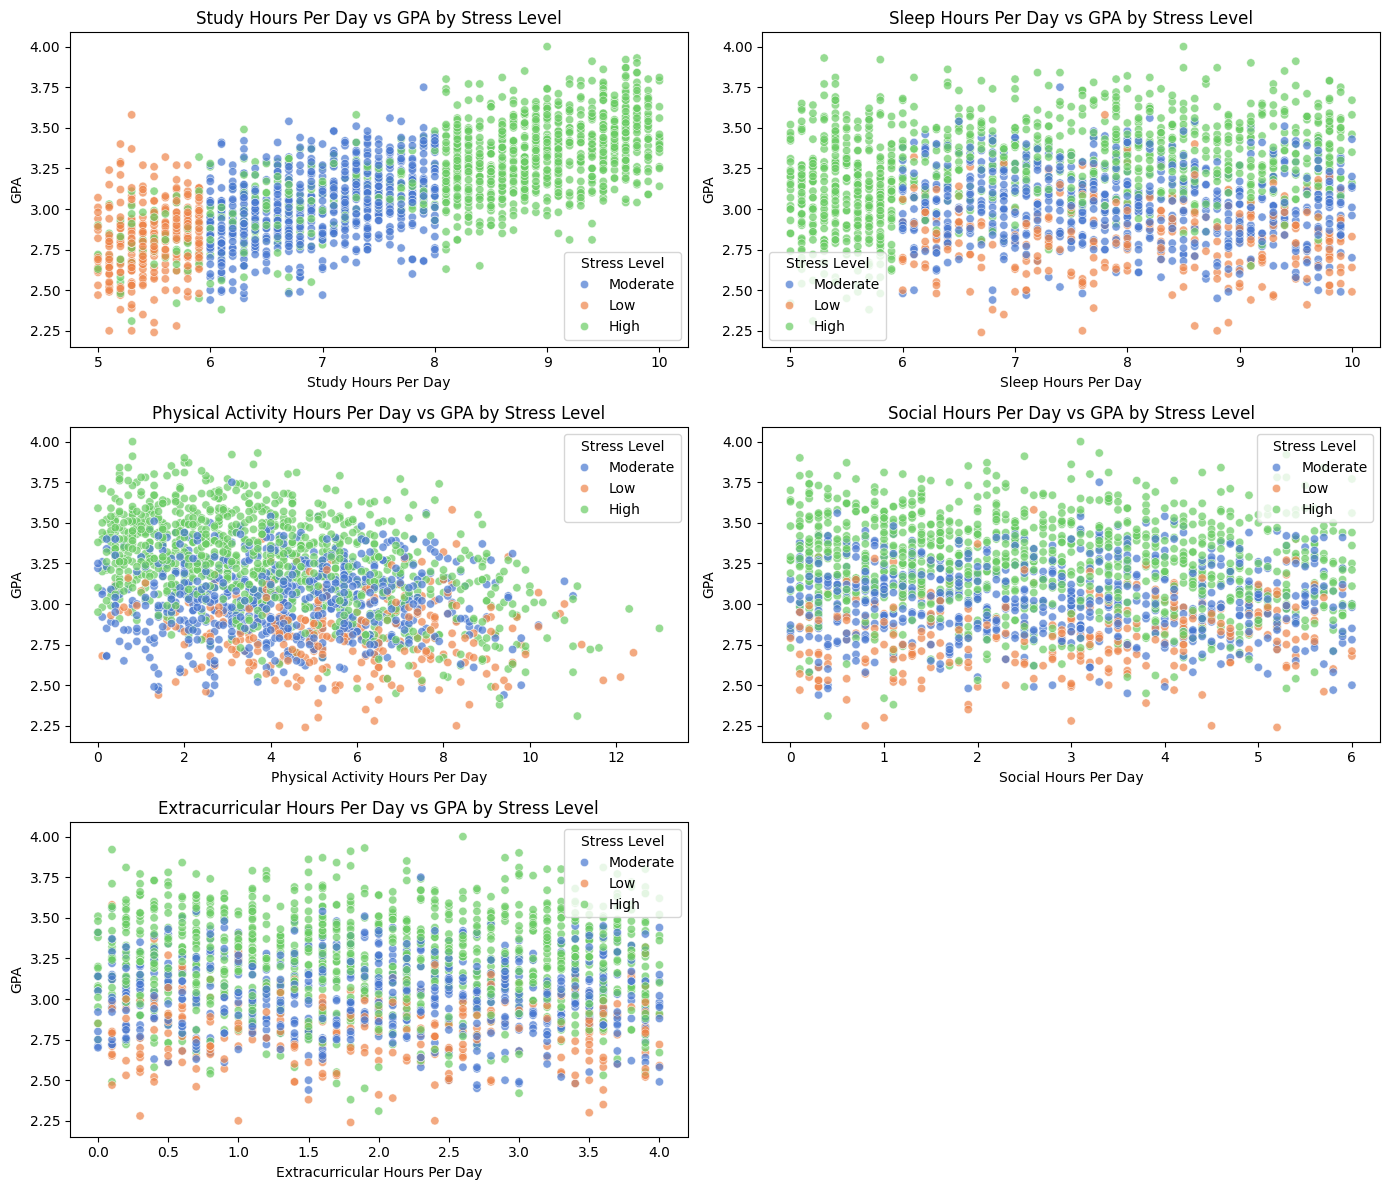

In [ ]:
# Numerical features against GPA, grouped by Stress_Level
plt.figure(figsize=(14, 12))

numerical_features = [
    'Study_Hours_Per_Day',
    'Sleep_Hours_Per_Day',
    'Physical_Activity_Hours_Per_Day',
    'Social_Hours_Per_Day',
    'Extracurricular_Hours_Per_Day'
]

# Plot each feature
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(
        x=feature,
        y='GPA',
        hue='Stress_Level',
        data=df,
        palette='muted',
        alpha=0.7
    )
    plt.title(f'{feature.replace("_", " ")} vs GPA by Stress Level')
    plt.xlabel(feature.replace('_', ' '))
    plt.ylabel('GPA')
    plt.legend(title='Stress Level')

plt.tight_layout()
plt.show()

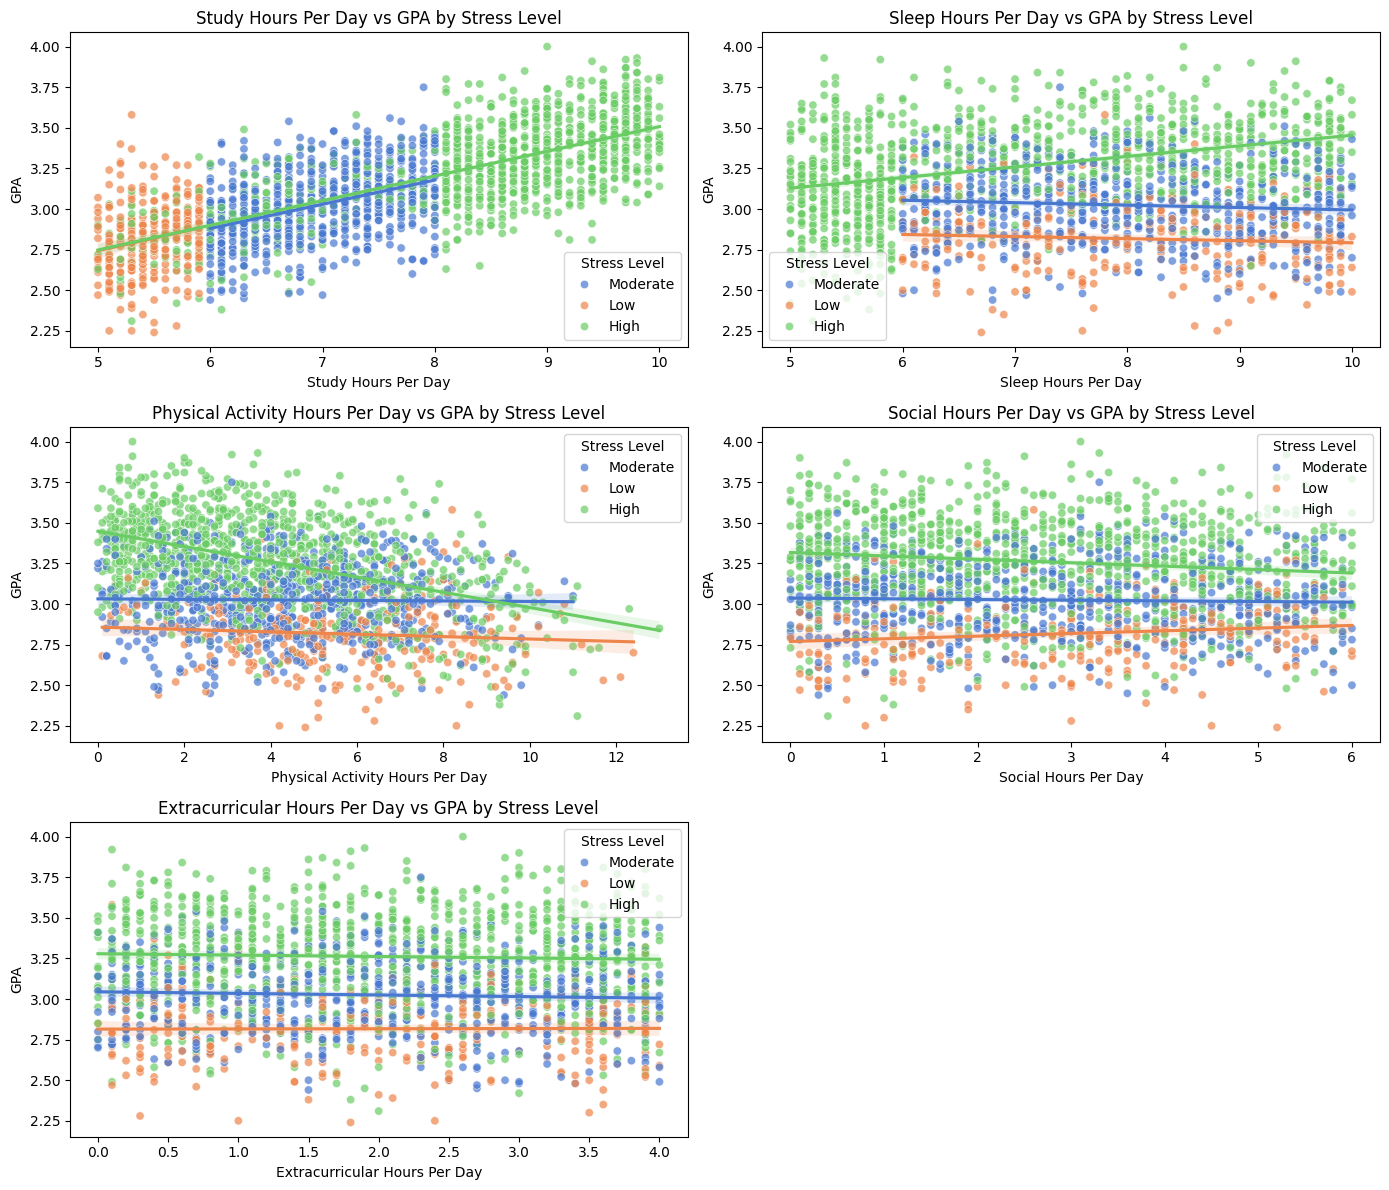

In [ ]:
plt.figure(figsize=(14, 12))

numerical_features = [
    'Study_Hours_Per_Day',
    'Sleep_Hours_Per_Day',
    'Physical_Activity_Hours_Per_Day',
    'Social_Hours_Per_Day',
    'Extracurricular_Hours_Per_Day'
]

# Define colors for different stress levels
stress_colors = sns.color_palette('muted')

# Plot each feature
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 2, i + 1)

    # Scatter plot with matching colors for stress levels
    sns.scatterplot(
        x=feature,
        y='GPA',
        hue='Stress_Level',
        data=df,
        palette=stress_colors,
        alpha=0.7
    )

    # Add linear regression lines for each stress level with matching colors
    for j, stress_level in enumerate(df['Stress_Level'].unique()):
        sns.regplot(
            x=feature,
            y='GPA',
            data=df[df['Stress_Level'] == stress_level],
            scatter=False,
            color=stress_colors[j], # Use the same color for the line as in the scatter plot
            line_kws={'label': stress_level}
        )

    plt.title(f'{feature.replace("_", " ")} vs GPA by Stress Level')
    plt.xlabel(feature.replace('_', ' '))
    plt.ylabel('GPA')
    plt.legend(title='Stress Level')

plt.tight_layout()
plt.show()

In [ ]:
# Define thresholds for low and high GPA
low_gpa_threshold = 2.5
high_gpa_threshold = 3.5

# Filter students with low GPA (less than or equal to the threshold)
low_gpa_students = df[df['GPA'] <= low_gpa_threshold][
    ['GPA', 'Study_Hours_Per_Day', 'Physical_Activity_Hours_Per_Day', 'Stress_Level']
]

# Display results in a clear format
print("----- Students with Low GPA (<= 2.5) -----")
display(low_gpa_students)

# Filter students with high GPA (equal to the threshold)
high_gpa_students = df[df['GPA'] >= high_gpa_threshold][
    ['GPA', 'Study_Hours_Per_Day', 'Physical_Activity_Hours_Per_Day', 'Stress_Level']
]

# Display results in a clear format
print("\n----- Students with High GPA (>= 3.5) -----")
display(high_gpa_students)

----- Students with Low GPA (<= 2.5) -----


GPA  Study_Hours_Per_Day  Physical_Activity_Hours_Per_Day Stress_Level
32    2.47                  5.2                              7.9          Low
56    2.39                  5.3                              5.1          Low
134   2.45                  6.3                              2.6     Moderate
158   2.38                  6.1                              9.3         High
165   2.46                  5.8                              2.5          Low
283   2.50                  6.2                              9.8     Moderate
331   2.25                  5.1                              8.3          Low
377   2.28                  5.7                              6.4          Low
382   2.31                  5.3                             11.1         High
504   2.49                  5.2                              4.6          Low
505   2.44                  6.0                              9.4     Moderate
512   2.49                  6.7                              9.1         High
550   2.48                  6.7                              7.5     Moderate
605   2.41                  5.3                              6.5          Low
651   2.49                  5.3                              6.3          Low
659   2.49                  6.1                              1.4     Moderate
742   2.48                  5.2                              6.0         High
764   2.24                  5.5                              4.8          Low
815   2.50                  5.6                              5.5          Low
862   2.45                  5.9                              6.9         High
901   2.48                  6.3                              5.2     Moderate
934   2.49                  5.1                              9.2          Low
997   2.49                  5.8                              9.5          Low
1034  2.38                  5.2                              8.6          Low
1074  2.44                  5.5                              1.4          Low
1122  2.50                  6.0                              2.7     Moderate
1172  2.30                  5.5                              5.1          Low
1388  2.50                  5.7                              6.8          Low
1427  2.47                  7.0                              1.4     Moderate
1443  2.42                  5.7                              9.3         High
1574  2.25                  5.3                              4.2          Low
1686  2.50                  5.1                              5.6          Low
1700  2.35                  5.4                              6.2          Low
1727  2.49                  6.8                              1.3     Moderate
1734  2.50                  6.1                              2.5     Moderate
1851  2.48                  5.9                              7.0          Low
1857  2.47                  5.0                              5.5          Low


----- Students with High GPA (>= 3.5) -----


GPA  Study_Hours_Per_Day  Physical_Activity_Hours_Per_Day Stress_Level
4     3.51                  8.1                              6.6         High
34    3.62                  9.7                              6.3         High
45    3.55                  9.7                              0.6         High
51    4.00                  9.0                              0.8         High
60    3.67                  8.3                              1.3         High
...    ...                  ...                              ...          ...
1939  3.52                  8.1                              2.4         High
1962  3.59                  9.4                              2.9         High
1964  3.54                  9.9                              3.0         High
1987  3.86                  9.5                              3.6         High
1999  3.58                  9.0                              2.9         High

[221 rows x 4 columns]

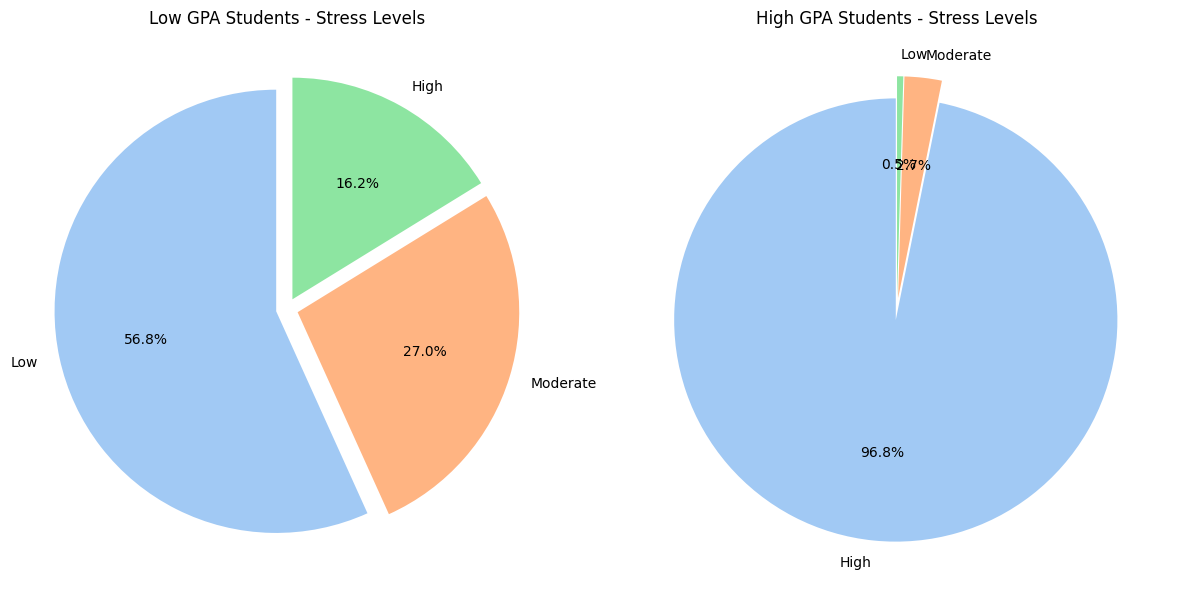

In [ ]:
# Prepare data for low GPA students' stress levels
low_gpa_stress_counts = low_gpa_students['Stress_Level'].value_counts()

# Prepare data for high GPA students' stress levels
high_gpa_stress_counts = high_gpa_students['Stress_Level'].value_counts()

# Create subplots for pie charts
plt.figure(figsize=(12, 6))

# Low GPA students' stress levels pie chart
plt.subplot(1, 2, 1)
low_gpa_stress_counts.plot.pie(
    autopct='%1.1f%%',
    colors=sns.color_palette('pastel'),
    startangle=90,
    explode=[0.05] * len(low_gpa_stress_counts),
    labels=low_gpa_stress_counts.index
)
plt.title('Low GPA Students - Stress Levels')
plt.ylabel('')

# High GPA students' stress levels pie chart
plt.subplot(1, 2, 2)
high_gpa_stress_counts.plot.pie(
    autopct='%1.1f%%',
    colors=sns.color_palette('pastel'),
    startangle=90,
    explode=[0.05] * len(high_gpa_stress_counts),
    labels=high_gpa_stress_counts.index
)
plt.title('High GPA Students - Stress Levels')
plt.ylabel('')

# Show the plots
plt.tight_layout()
plt.show()

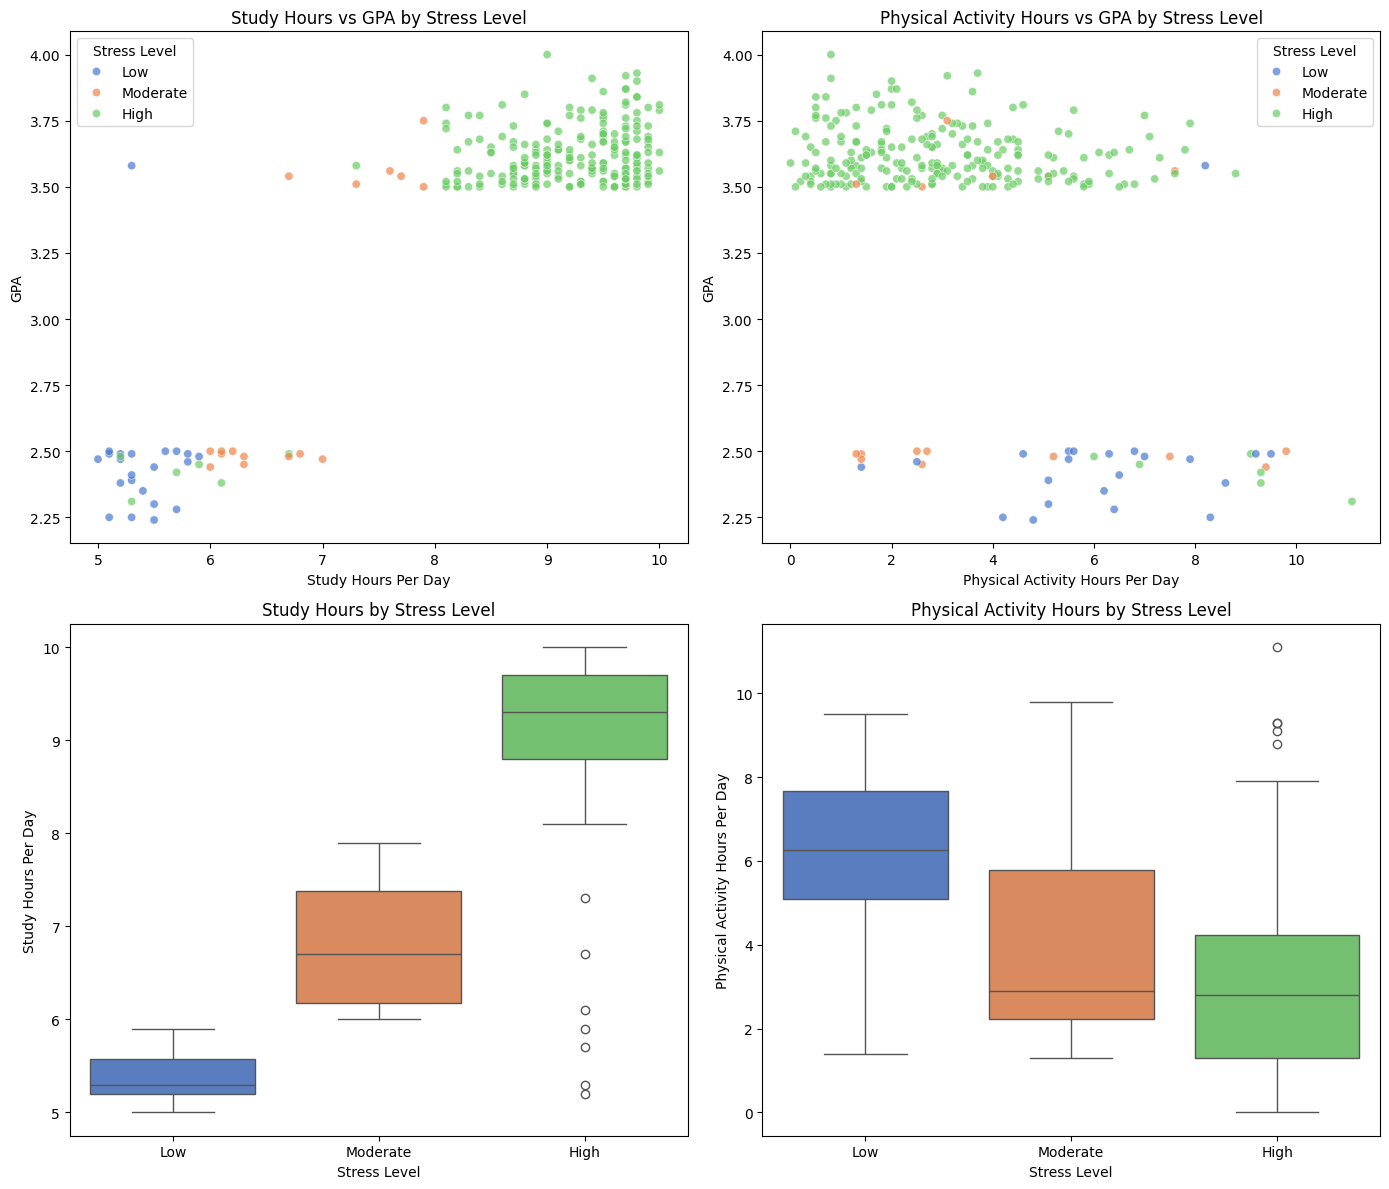

In [ ]:
# Combine low and high GPA students for comparison
low_high_gpa_comparison = pd.concat([low_gpa_students, high_gpa_students])

# Create scatter plots to compare study hours and physical activity hours with stress level and GPA
plt.figure(figsize=(14, 12))

# Study Hours vs GPA
plt.subplot(2, 2, 1)
sns.scatterplot(
    x='Study_Hours_Per_Day',
    y='GPA',
    hue='Stress_Level',
    data=low_high_gpa_comparison,
    palette='muted',
    alpha=0.7
)
plt.title('Study Hours vs GPA by Stress Level')
plt.xlabel('Study Hours Per Day')
plt.ylabel('GPA')
plt.legend(title='Stress Level')

# Physical Activity Hours vs GPA
plt.subplot(2, 2, 2)
sns.scatterplot(
    x='Physical_Activity_Hours_Per_Day',
    y='GPA',
    hue='Stress_Level',
    data=low_high_gpa_comparison,
    palette='muted',
    alpha=0.7
)
plt.title('Physical Activity Hours vs GPA by Stress Level')
plt.xlabel('Physical Activity Hours Per Day')
plt.ylabel('GPA')
plt.legend(title='Stress Level')

# Study Hours vs Stress Level
plt.subplot(2, 2, 3)
sns.boxplot(
    x='Stress_Level',
    y='Study_Hours_Per_Day',
    data=low_high_gpa_comparison,
    palette='muted'
)
plt.title('Study Hours by Stress Level')
plt.xlabel('Stress Level')
plt.ylabel('Study Hours Per Day')

# Physical Activity Hours vs Stress Level
plt.subplot(2, 2, 4)
sns.boxplot(
    x='Stress_Level',
    y='Physical_Activity_Hours_Per_Day',
    data=low_high_gpa_comparison,
    palette='muted'
)
plt.title('Physical Activity Hours by Stress Level')
plt.xlabel('Stress Level')
plt.ylabel('Physical Activity Hours Per Day')

plt.tight_layout()
plt.show()

In [ ]:
# Identify the maximum and minimum GPA in the dataset
max_gpa = df['GPA'].max()
min_gpa = df['GPA'].min()

# Count the number of students with maximum and minimum GPA
num_students_max_gpa = df[df['GPA'] == max_gpa].shape[0]
num_students_min_gpa = df[df['GPA'] == min_gpa].shape[0]

max_gpa_info = {
    "Max GPA": max_gpa,
    "Number of Students with Max GPA": num_students_max_gpa
}

min_gpa_info = {
    "Min GPA": min_gpa,
    "Number of Students with Min GPA": num_students_min_gpa
}

print("--- GPA Summary Statistics ---\n")
print("Maximum GPA Information:")
for key, value in max_gpa_info.items():
    print(f"- {key}: {value}")

print("\nMinimum GPA Information:")
for key, value in min_gpa_info.items():
    print(f"- {key}: {value}")

--- GPA Summary Statistics ---

Maximum GPA Information:
- Max GPA: 4.0
- Number of Students with Max GPA: 1

Minimum GPA Information:
- Min GPA: 2.24
- Number of Students with Min GPA: 1


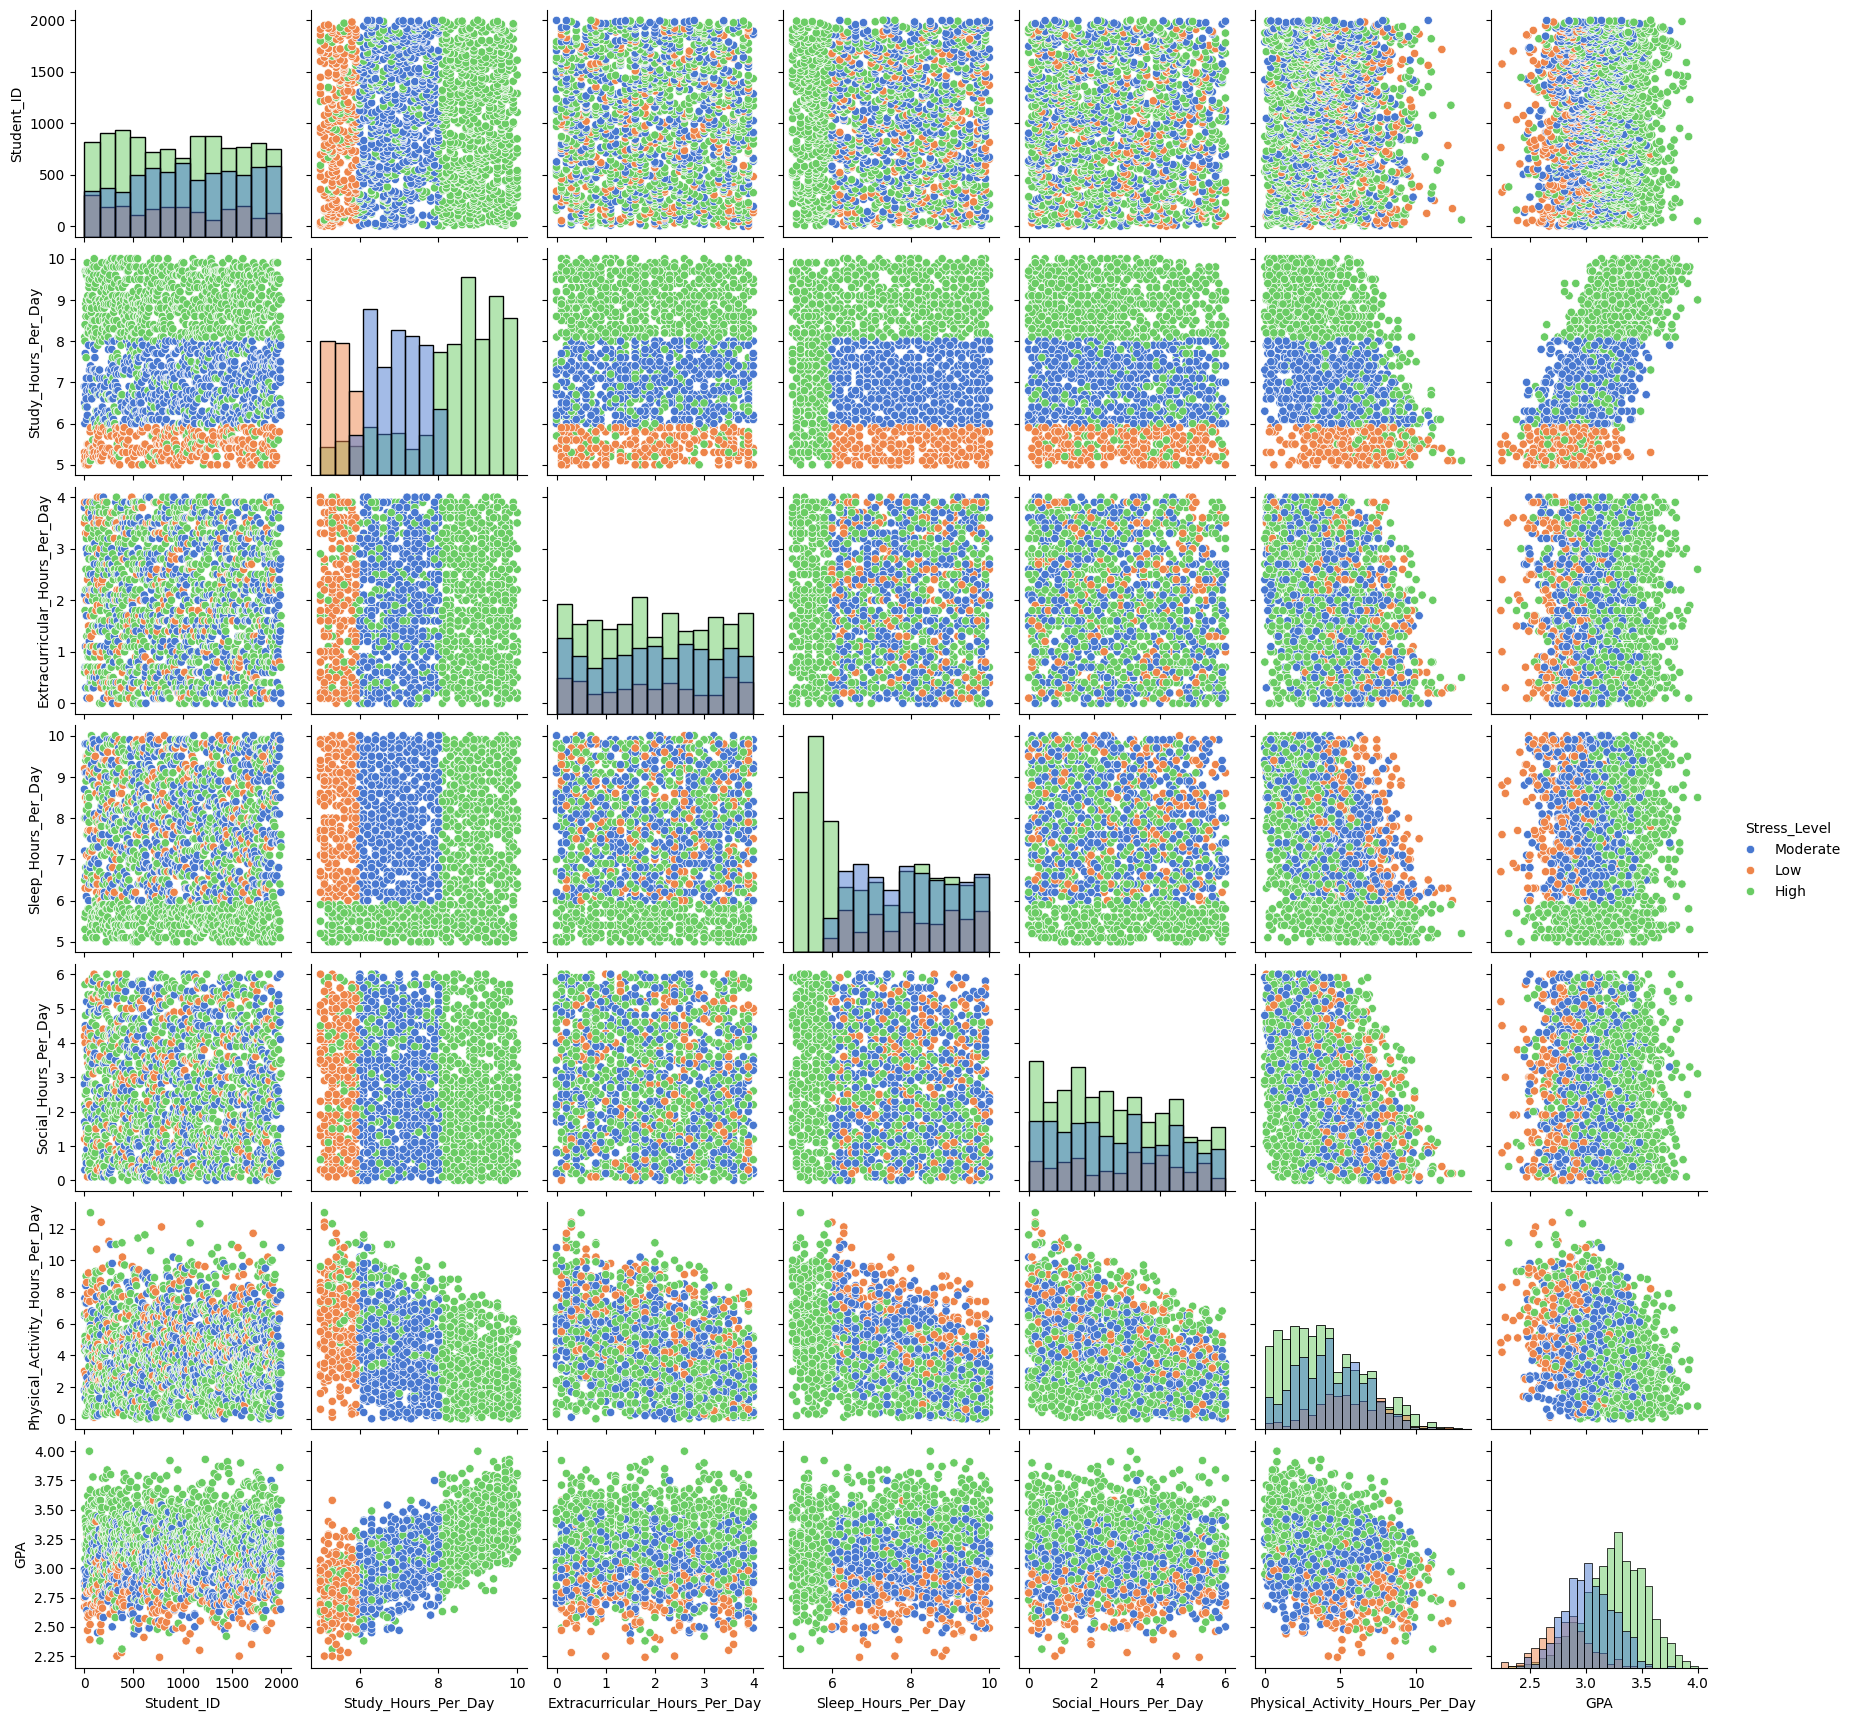

In [ ]:
sns.pairplot(df, hue='Stress_Level', diag_kind='hist', palette='muted')

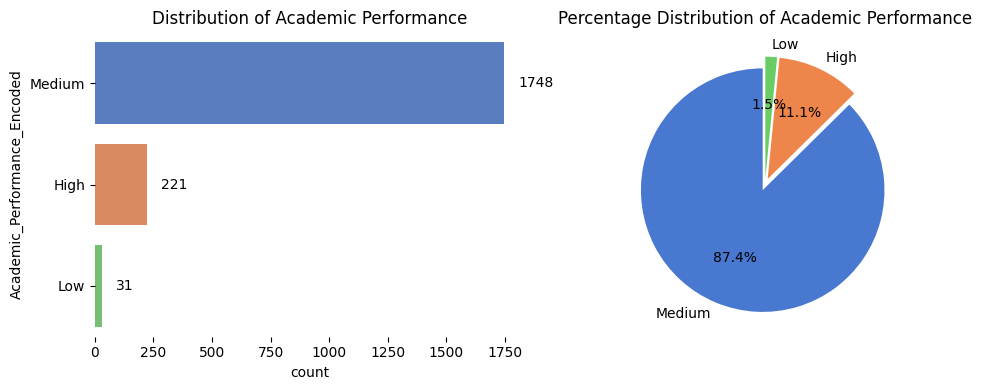

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Encode GPA into categories (Low, Medium, High)
def encode_performance(gpa):
    if gpa < 2.5:
        return 'Low'
    elif 2.5 <= gpa < 3.5:
        return 'Medium'
    else:
        return 'High'

# Apply encoding
df['Academic_Performance_Encoded'] = df['GPA'].apply(encode_performance)

# Convert to categorical for plotting
df['Academic_Performance_Encoded'] = df['Academic_Performance_Encoded'].astype(str)

# Set figure size
plt.figure(figsize=(10, 4))

# First subplot: Count plot
plt.subplot(1, 2, 1)
sns.countplot(y='Academic_Performance_Encoded', data=df, palette='muted')
plt.title('Distribution of Academic Performance')

# Annotate bar values
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center', xytext=(10, 0), textcoords='offset points')

sns.despine(left=True, bottom=True)

# Second subplot: Pie chart
plt.subplot(1, 2, 2)
value_counts = df['Academic_Performance_Encoded'].value_counts()

# Ensure explode length matches number of unique values
explode = [0.05] * len(value_counts)

value_counts.plot.pie(autopct='%1.1f%%', colors=sns.color_palette('muted'),
                      startangle=90, explode=explode)
plt.title('Percentage Distribution of Academic Performance')
plt.ylabel('')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Ensure column names are clean
df.columns = df.columns.str.strip()

# ✅ Check if 'Academic_Performance_Encoded' exists instead of 'Academic_Performance'
if 'Academic_Performance' not in df.columns and 'Academic_Performance_Encoded' in df.columns:
    print("⚠️ Warning: 'Academic_Performance' is missing but 'Academic_Performance_Encoded' exists. Using the encoded column.")

# ✅ Restore 'Academic_Performance' (if needed)
if 'Academic_Performance' not in df.columns:
    reverse_mapping_performance = {0: 'Poor', 1: 'Fair', 2: 'Good', 3: 'Excellent'}
    df['Academic_Performance'] = df['Academic_Performance_Encoded'].map(reverse_mapping_performance)

# ✅ Mapping for Stress_Level (ordinal encoding)
mapping_stress = {'Low': 0, 'Moderate': 1, 'High': 2}
df['Stress_Level_Encoded'] = df['Stress_Level'].map(mapping_stress)

# ✅ Mapping for Academic_Performance (ordinal encoding) - Only if missing
if 'Academic_Performance_Encoded' not in df.columns:
    mapping_performance = {'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3}
    df['Academic_Performance_Encoded'] = df['Academic_Performance'].map(mapping_performance)

# ✅ Display first 10 rows to verify
print(df[['Stress_Level', 'Stress_Level_Encoded', 'Academic_Performance', 'Academic_Performance_Encoded']].head(10))


⚠️ Warning: 'Academic_Performance' is missing but 'Academic_Performance_Encoded' exists. Using the encoded column.
  Stress_Level  Stress_Level_Encoded Academic_Performance  \
0     Moderate                     1                  NaN   
1          Low                     0                  NaN   
2          Low                     0                  NaN   
3     Moderate                     1                  NaN   
4         High                     2                  NaN   
5     Moderate                     1                  NaN   
6         High                     2                  NaN   
7         High                     2                  NaN   
8          Low                     0                  NaN   
9     Moderate                     1                  NaN   

  Academic_Performance_Encoded  
0                       Medium  
1                       Medium  
2                       Medium  
3                       Medium  
4                         High  
5              

In [ ]:
# Drop the original categorical columns
df = df.drop(columns=['Stress_Level', 'Academic_Performance'])

# Verify the updated dataset
df.head()

Student_ID  Study_Hours_Per_Day  Extracurricular_Hours_Per_Day  \
0           1                  6.9                            3.8   
1           2                  5.3                            3.5   
2           3                  5.1                            3.9   
3           4                  6.5                            2.1   
4           5                  8.1                            0.6   

   Sleep_Hours_Per_Day  Social_Hours_Per_Day  Physical_Activity_Hours_Per_Day  \
0                  8.7                   2.8                              1.8   
1                  8.0                   4.2                              3.0   
2                  9.2                   1.2                              4.6   
3                  7.2                   1.7                              6.5   
4                  6.5                   2.2                              6.6   

    GPA Academic_Performance_Encoded  Stress_Level_Encoded  
0  2.99                       Medium                     1  
1  2.75                       Medium                     0  
2  2.67                       Medium                     0  
3  2.88                       Medium                     1  
4  3.51                         High                     2

In [ ]:
import pandas as pd

# Ensure 'Stress_Level_Encoded' is numeric
if not pd.api.types.is_numeric_dtype(df['Stress_Level_Encoded']):
    print("⚠️ Warning: 'Stress_Level_Encoded' contains non-numeric values. Check encoding!")

# Selecting only numeric columns for correlation
numeric_df = df.select_dtypes(include=['number'])

# Creating the correlation table
target_variable = 'Stress_Level_Encoded'

# Check if target variable exists in numeric columns
if target_variable not in numeric_df.columns:
    raise ValueError(f"'{target_variable}' is not a numeric column! Ensure proper encoding.")

# Compute correlation
target_correlation_table = numeric_df.corr()[[target_variable]].sort_values(by=target_variable, ascending=False)

# Display the table
print(target_correlation_table)


                                 Stress_Level_Encoded
Stress_Level_Encoded                         1.000000
Study_Hours_Per_Day                          0.738843
GPA                                          0.550395
Student_ID                                   0.003306
Extracurricular_Hours_Per_Day               -0.006099
Social_Hours_Per_Day                        -0.054702
Physical_Activity_Hours_Per_Day             -0.205207
Sleep_Hours_Per_Day                         -0.298917


In [ ]:
# Define the features (X) and the target variable (y)
X = df.drop(columns=['Student_ID', 'Stress_Level_Encoded'])
y = df['Stress_Level_Encoded']

# Display shapes to confirm the split
print("X Shape:", X.shape)
print("\ny Shape:", y.shape)

X Shape: (2000, 7)

y Shape: (2000,)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest

# Ensure all categorical columns are properly encoded
categorical_columns = df.select_dtypes(include=['object']).columns

# Encode categorical variables using ordinal encoding (if not already encoded)
df_encoded = df.copy()
for col in categorical_columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# Selecting numeric features only
X = df_encoded.select_dtypes(include=['number'])

# Outlier detection using Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outlier_predictions = iso_forest.fit_predict(X)

# Identify outliers: Isolation Forest marks outliers as -1
outlier_indices = X.index[outlier_predictions == -1]

# Print the number of outliers detected
print(f"Number of detected outliers: {len(outlier_indices)}")


Number of detected outliers: 20


In [ ]:
# Remove outliers
X_filtered = X.drop(outlier_indices, axis=0).reset_index(drop=True)
y_filtered = y.drop(outlier_indices, axis=0).reset_index(drop=True)

print(f"New shape of X after removing outliers: {X_filtered.shape}")
print(f"New shape of y after removing outliers: {y_filtered.shape}")

New shape of X after removing outliers: (1980, 9)
New shape of y after removing outliers: (1980,)


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Display the shapes of the splits for verification
print("X_train Shape:", X_train.shape)
print("X_test Shape:", X_test.shape)
print("y_train Shape:", y_train.shape)
print("y_test Shape:", y_test.shape)

X_train Shape: (1584, 9)
X_test Shape: (396, 9)
y_train Shape: (1584,)
y_test Shape: (396,)


In [ ]:
print(X_train.dtypes)

Student_ID                           int64
Study_Hours_Per_Day                float64
Extracurricular_Hours_Per_Day      float64
Sleep_Hours_Per_Day                float64
Social_Hours_Per_Day               float64
Physical_Activity_Hours_Per_Day    float64
GPA                                float64
Academic_Performance_Encoded          int8
Stress_Level_Encoded                 int64
dtype: object


In [ ]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)


In [ ]:
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [ ]:
# Apply RobustScaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Display model names to confirm initialization
print("Models initialized:", list(models.keys()))

Models initialized: ['Logistic Regression', 'Decision Tree', 'Random Forest']


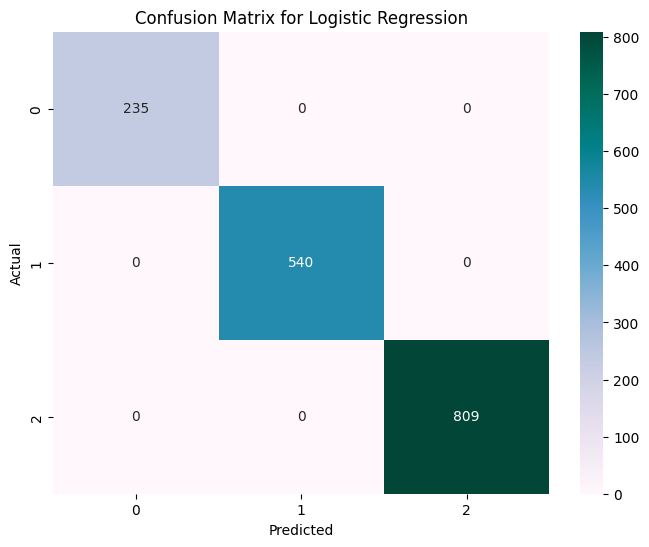


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       235
           1       1.00      1.00      1.00       540
           2       1.00      1.00      1.00       809

    accuracy                           1.00      1584
   macro avg       1.00      1.00      1.00      1584
weighted avg       1.00      1.00      1.00      1584



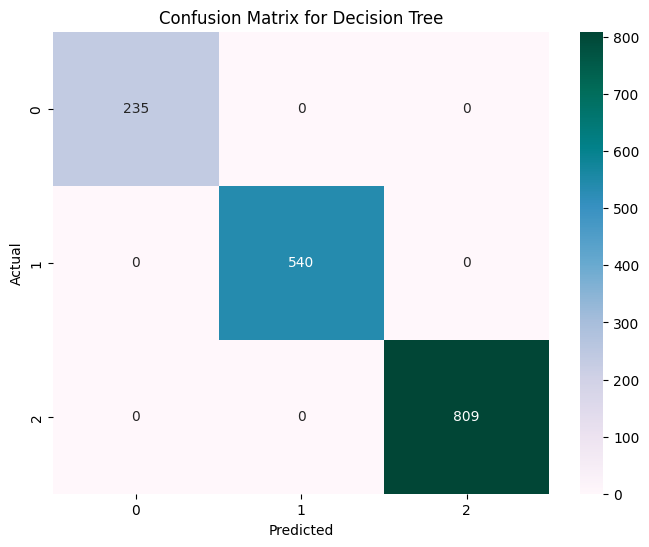


Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       235
           1       1.00      1.00      1.00       540
           2       1.00      1.00      1.00       809

    accuracy                           1.00      1584
   macro avg       1.00      1.00      1.00      1584
weighted avg       1.00      1.00      1.00      1584



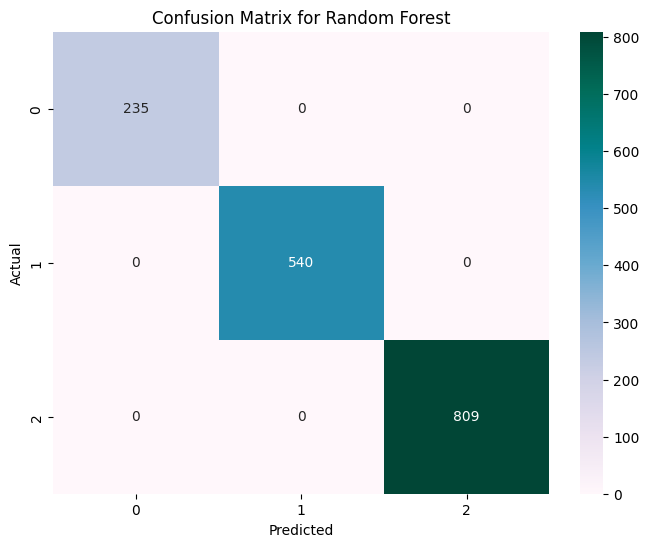


Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       235
           1       1.00      1.00      1.00       540
           2       1.00      1.00      1.00       809

    accuracy                           1.00      1584
   macro avg       1.00      1.00      1.00      1584
weighted avg       1.00      1.00      1.00      1584


Model Evaluation Summary:



Accuracy  AUC
Logistic Regression       1.0  1.0
Decision Tree             1.0  1.0
Random Forest             1.0  1.0

In [ ]:
def train_and_evaluate_models(models, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models.items():
        # Train the model on the training data
        model.fit(X_train, y_train)

        # Predict on the test set
        preds = model.predict(X_test)

        # Calculate metrics on the training data
        accuracy = accuracy_score(y_train, model.predict(X_train))
        auc = (
            roc_auc_score(y_train, model.predict_proba(X_train), multi_class="ovr")
            if hasattr(model, 'predict_proba') else 'N/A'
        )

        results[name] = {
            'Accuracy': accuracy,
            'AUC': auc,
            'Predictions': preds
        }

        # Display confusion matrix for training data
        conf_matrix = confusion_matrix(y_train, model.predict(X_train))
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='PuBuGn',
                    xticklabels=model.classes_, yticklabels=model.classes_)
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Display classification report for training data
        print(f"\nClassification Report for {name}:\n")
        print(classification_report(y_train, model.predict(X_train)))

    results_df = pd.DataFrame({
        name: {"Accuracy": results[name]["Accuracy"], "AUC": results[name]["AUC"]}
        for name in results
    }).T

    # Display the summary DataFrame
    print("\nModel Evaluation Summary:\n")
    return results_df

evaluation_summary = train_and_evaluate_models(models, X_train, y_train, X_test, y_test)

# Display the evaluation summary
evaluation_summary

In [ ]:
# Define the base models for stacking
base_models = [
    ('lr', LogisticRegression(random_state=42, max_iter=1000)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
]

# Define the meta-model for stacking
meta_model = RandomForestClassifier(random_state=42)

# Create the stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

cv_scores = cross_val_score(stacking_model, X_train, y_train, cv=5, scoring='accuracy')

stacking_model.fit(X_train, y_train)

test_accuracy = stacking_model.score(X_test, y_test)

# Display the cross-validation scores and test accuracy
{
    "Cross-Validation Scores": cv_scores.tolist(),
    "Mean CV Accuracy": cv_scores.mean(),
    "Test Set Accuracy": test_accuracy
}

{'Cross-Validation Scores': [1.0, 1.0, 1.0, 1.0, 1.0],
 'Mean CV Accuracy': 1.0,
 'Test Set Accuracy': 1.0}

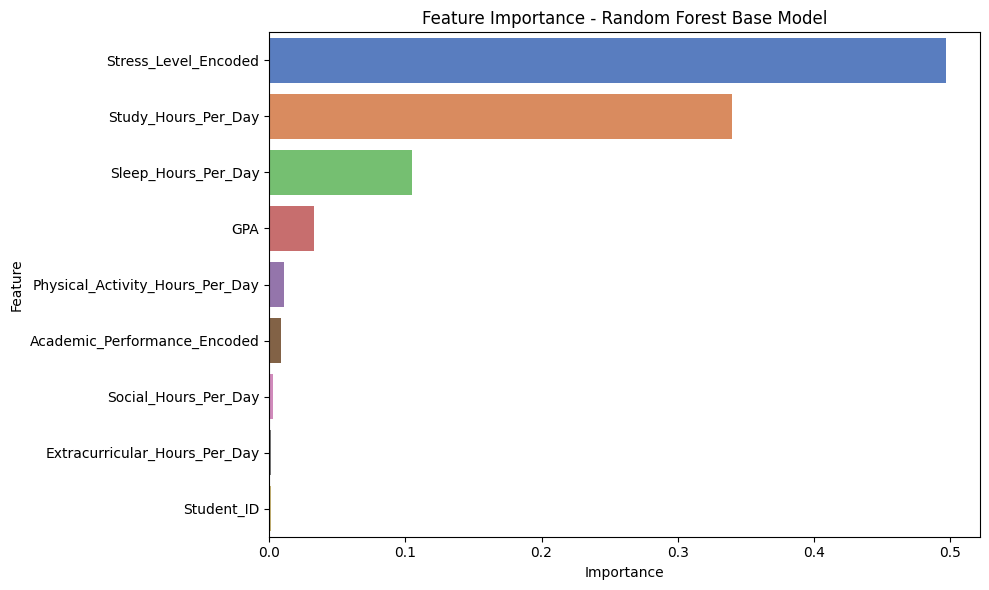

In [ ]:
# Use the feature names from the original DataFrame
feature_names = X.columns  # Retrieve feature names from the original DataFrame

# Extract feature importance from the Random Forest base model
rf_base_model = stacking_model.named_estimators_['rf']  # Access Random Forest base model
rf_feature_importances = rf_base_model.feature_importances_

# Create a DataFrame to visualize feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='muted')
plt.title('Feature Importance - Random Forest Base Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

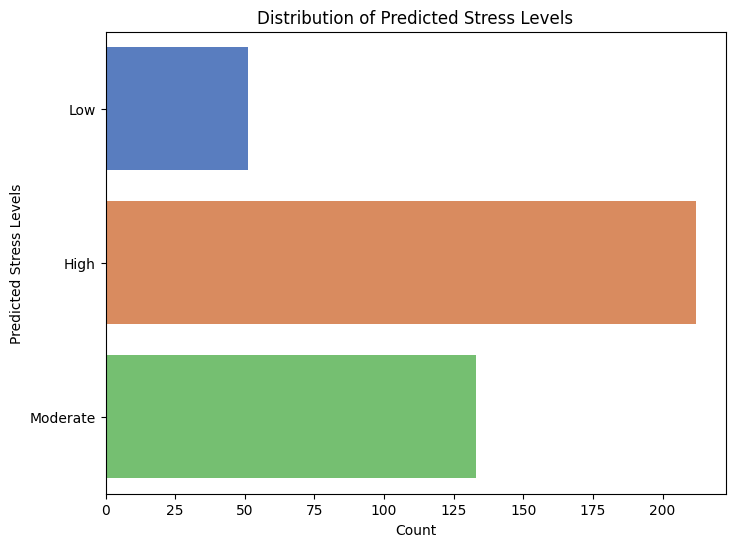

In [ ]:
# Generate predictions on the test set using the stacking model
y_pred = stacking_model.predict(X_test)

# Map the encoded predictions back to the original stress level categories
mapping_stress_reverse = {0: 'Low', 1: 'Moderate', 2: 'High'}
y_pred_mapped = pd.Series(y_pred).map(mapping_stress_reverse)

# Plot the distribution of predicted stress levels
plt.figure(figsize=(8, 6))
sns.countplot(y=y_pred_mapped, palette='muted')
plt.title('Distribution of Predicted Stress Levels')
plt.xlabel('Count')
plt.ylabel('Predicted Stress Levels')
plt.show()